# Part 3C: Analysis of Results from Best Model



In [2]:
# install dependencies

!pip install -q bertopic
!pip install -U -q spacy
!pip install -q texthero==1.0.9

In [3]:
# import libraries

import os
import pandas as pd
pd.set_option('display.max_columns', 200)
import re
import numpy as np
from numpy import arange, argmax
import matplotlib.pyplot as plt
import os
import seaborn as sns
import random
from multiprocessing import Pool
from tqdm import tqdm
import math

import tensorflow as tf
import tensorflow_hub as hub
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import ParameterGrid

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap.umap_ as umap
import plotly.express as px
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import texthero as hero
from nltk import word_tokenize
import nltk
nltk.download('punkt')
import spacy

from absl import logging

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Load Data

In [5]:
# load data

data_path = '/content/drive/MyDrive/data606-capstone/William Simpson - Capstone 606/3. Datasets'

# data of election related fatalities
deco = pd.read_csv(os.path.join(data_path,'DECO_v.1.0.csv'))

# curated news dataset from Part 2
news = pd.read_csv(os.path.join(data_path,'relevant_kenya_news_AUG2016-NOV2017_FINAL_BEST.csv'), 
                   lineterminator='\n', index_col=0, parse_dates=['DATE'])


# 2. Data Preparation

### 2.1 Prepare DECO election violence data

In [6]:
# get election violence by selected country

country_selected = 'Kenya'
country_deco = deco.loc[deco.country==country_selected].copy()

In [7]:
# convert dates to datetime object

country_deco['date_start'] = pd.to_datetime(country_deco.date_start)
country_deco['date_end'] = pd.to_datetime(country_deco.date_end)

In [8]:
# view DECO data

country_deco

,id,type_of_violence,conflict_new_id,conflict_name,dyad_new_id,side_a_new_id,side_a,side_b_new_id,side_b,country_id,country,region,source_article,year,date_start,date_end,deaths_a,deaths_b,civilian_deaths,unknown,best,high,low,latitude,longitude,electoral_vio,electoral_vio_uncertainty,electoral_vio_source,electoral_purpose,electoral_side_a,electoral_side_a_2,electoral_side_a_inc,electoral_side_b,electoral_side_b_2,electoral_side_b_inc,electoral_perpetrator,electoral_targets,electoral_type,electoral_timing,relid,ucdp_ged
1217,40800,2,4953,Degodia - Garre,5563,918,Degodia,1079,Garre,501,Kenya,Africa,"Capital FM/All Africa 2012-08-21 ""Five People ...",2012,2012-08-20,2012-08-20,5,0,0,0,5,5,5,3.500000,40.75,1,1,NaN,preemptive violence,Other,NaN,0,Other,NaN,0,2,3,1;2,1,KEN-2012-2-435-2,1
1218,40804,2,4953,Degodia - Garre,5563,918,Degodia,1079,Garre,501,Kenya,Africa,"NTV 2012-08-25 through BBC ""Situation in volat...",2012,2012-08-23,2012-08-23,0,1,0,0,1,1,1,1.747220,40.0689,1,2,NaN,preemptive violence,Other,NaN,0,Other,NaN,0,2,3,1;2,1,KEN-2012-2-435-5,1
1219,40805,2,4953,Degodia - Garre,5563,918,Degodia,1079,Garre,501,Kenya,Africa,"The Standard 2012-08-27 through BBC ""Four more...",2012,2012-08-26,2012-08-26,0,0,0,4,4,4,4,3.860000,40.5,1,2,NaN,preemptive violence,Other,NaN,0,Other,NaN,0,2,3,1;2,1,KEN-2012-2-435-6,1
1220,40808,2,9601,Kalenjin - Luo,10211,1024,Kalenjin,901,Luo,501,Kenya,Africa,"The Star 2012-03-02 through BBC 2012-03-03 ""Ke...",2012,2012-02-24,2012-02-26,0,0,0,6,6,6,6,0.500000,36,1,1,NaN,disrupt,Other,NaN,0,Other,NaN,0,3,3,1;2,1,KEN-2012-2-X983-1,0
1221,40816,2,11216,Meru - Turkana,11826,3546,Meru,693,Turkana,501,Kenya,Africa,"IRIN 2012-02-15 ""KENYA: Hundreds displaced by ...",2012,2012-02-13,2012-02-13,0,0,0,3,3,3,3,0.401147,37.685247,1,1,NaN,disrupt,Other,NaN,0,Other,NaN,0,3,3,1;2,1,KEN-2012-2-X5097-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4228,253925,3,469,Government of Kenya - Civilians,936,91,Government of Kenya,1,Civilians,501,Kenya,Africa,"""Human Rights Watch,2018-02-25,Kenya: Fresh Ev...",2017,2017-10-31,2017-10-31,0,0,1,0,1,1,1,-1.283333,36.816667,1,1,NaN,crack down on protest and/or riot,Security forces,NaN,1,Civilians,NaN,0,1,5,2,3,KEN-2017-3-936-70,1
4229,253926,4,13998,Government of Kenya - Opponents of Kenyatta,15173,91,Government of Kenya,6777,Opponents of Kenyatta,501,Kenya,Africa,"""Human Rights Watch,2018-02-25,Kenya: Fresh Ev...",2017,2017-11-17,2017-11-17,0,0,0,1,1,1,1,-1.283333,36.816667,1,2,NaN,crack down on protest and/or riot,Security forces,NaN,1,Civilians,NaN,0,1,5,2,3,KEN-2017-4-15173-57,0
4230,253927,3,469,Government of Kenya - Civilians,936,91,Government of Kenya,1,Civilians,501,Kenya,Africa,"""Human Rights Watch,2018-02-25,Kenya: Fresh Ev...",2017,2017-11-20,2017-11-20,0,0,1,0,1,1,1,-1.283333,36.816667,1,2,NaN,crack down on protest and/or riot,Security forces,NaN,1,Civilians,NaN,0,1,5,2,3,KEN-2017-3-936-73,1
4231,253928,3,469,Government of Kenya - Civilians,936,91,Government of Kenya,1,Civilians,501,Kenya,Africa,"""Human Rights Watch,2018-02-25,Kenya: Fresh Ev...",2017,2017-11-28,2017-11-28,0,0,1,0,1,1,1,-1.283333,36.816667,1,2,NaN,crack down on protest and/or riot,Security forces,NaN,1,Civilians,NaN,0,1,5,2,3,KEN-2017-3-936-74,1


In [9]:
# filter for events of election violence in selected election cycle timeframe

country_deco_time = country_deco.loc[country_deco.date_start>'2016-08-07'].copy()
country_deco_time = country_deco_time.loc[country_deco_time.date_end<'2017-11-29'].copy()

print('min date:', country_deco_time.date_start.min())
print('max date:', country_deco_time.date_end.max())

min date: 2017-02-02 00:00:00
max date: 2017-11-28 00:00:00


In [10]:
# size data for Kenya 2017 election cycle

country_deco_time.shape

(98, 41)

In [11]:
# aggregate deaths by day

def agg_deco_one_day(deco_data):
    '''
    aggregates the count of election violence deaths each day

    Parameters:
    ———————————
    deco_data: pandas dataframe
        original deco data dataframe
    Outputs:
    ————————
    deco_data: pandas groupby object
        deco data grouped by day
    '''
    deco_data = deco_data[['date_start', 'best']]
    deco_data = deco_data.groupby(by=['date_start']).sum()
    
    return deco_data.reset_index()

In [12]:
# apply aggregation function

country_deco_day = agg_deco_one_day(country_deco_time)
country_deco_day

,date_start,best
0,2017-02-02,1
1,2017-03-19,10
2,2017-05-13,1
3,2017-05-20,1
4,2017-05-26,7
5,2017-06-01,21
6,2017-06-02,1
7,2017-07-28,2
8,2017-08-08,1
9,2017-08-09,17


In [13]:
# fill missing dates with zero fatalities

# get full date range
date_range = pd.date_range(start='2016-08-08', 
                  end=country_deco_day.date_start.max())
country_date_fill = country_deco_day.reindex(date_range).reset_index()

# merge full date range with dates of election violence
country_date_fill = country_date_fill.merge(country_deco_day, how='left', left_on='index', right_on='date_start')

# fill with zero fatalities
country_date_fill = country_date_fill.fillna(0)

# get relevant columns
country_date_fill = country_date_fill[['index', 'best_y']]
country_date_fill = country_date_fill.rename(columns={'best_y':'fatalities'})

In [14]:
country_date_fill[-50:]
                  

,index,fatalities
428,2017-10-10,0.0
429,2017-10-11,0.0
430,2017-10-12,0.0
431,2017-10-13,3.0
432,2017-10-14,0.0
433,2017-10-15,0.0
434,2017-10-16,1.0
435,2017-10-17,0.0
436,2017-10-18,0.0
437,2017-10-19,0.0


In [15]:
# aggregate fatalities by time unit

def agg_deco(deco_data, unit=1):
    '''
    get the sum of election related fatalities in a custom range of time
    
    Parameters:
    ———————————
    deco_data: pandas dataframe
        data of election fatalities by one day
    unit: int
        the number of days to group by

    Outputs:
    ————————
    deco_data: pandas dataframe
        transformed grouped data of election deaths
    '''
    deco_data = deco_data.set_index(['index'])
    deco_data = deco_data.groupby(pd.Grouper(freq=f'{unit}D')).sum()
    return deco_data

### 2.2 Prepare News Data

In [16]:
# prepare embedding model

logging.set_verbosity(logging.ERROR)

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
model = hub.load(module_url)

def embed(input):
    return model(input)

# 3. Use Best Model for Analysis

In [17]:
# define function to convert election fatalities target to categorical

# define binary class labels
pos_class = 1  # fatal class
neg_class = 0  # non-fatal class

# binary classes
def to_categorial_binary_3(val):
    if val <= 3:
        return neg_class
    else:
        return pos_class

In [18]:
def to_labels(pos_probs, threshold):
	'''
	function to convert predicted class probabilities to a class label from custom threshold

	Parameters:
	———————————
	pos_probs: numpy array, list
			positive class predicted probabilities
	threshold: int
			custom decision threshold

	Ouputs:
	———————
	(pos_probs >= threshold).astype('int'): numpy array, list
			list of class labels (0, 1)
	'''
	return (pos_probs >= threshold).astype('int')

### 3.1 Train Best Model

Aggregation: 5
Shift: -1
Categorical Function: <function to_categorial_binary_3 at 0x7f309aff80d0>


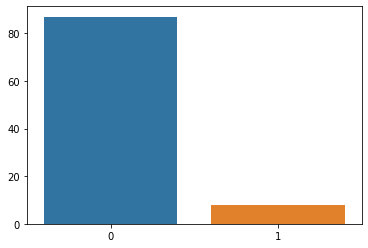

Model: <class 'sklearn.svm._classes.SVC'>


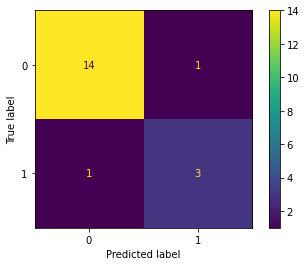

{0: {'precision': 0.9333333333333333, 'recall': 0.9333333333333333, 'f1-score': 0.9333333333333333, 'support': 15}, 1: {'precision': 0.75, 'recall': 0.75, 'f1-score': 0.75, 'support': 4}, 'accuracy': 0.8947368421052632, 'macro avg': {'precision': 0.8416666666666667, 'recall': 0.8416666666666667, 'f1-score': 0.8416666666666667, 'support': 19}, 'weighted avg': {'precision': 0.8947368421052632, 'recall': 0.8947368421052632, 'f1-score': 0.8947368421052632, 'support': 19}}


In [19]:
aggregations = [5]
shifts = [-1]
categories = [to_categorial_binary_3]
classifiers = [SVC]

for unit_of_aggregation in aggregations:
    print('Aggregation:', unit_of_aggregation)

    ### DATA PREPARATION ###
    # aggregate election fatalities by unit
    country_deco_grouped = agg_deco(country_date_fill, unit=unit_of_aggregation)
    
    # get average embeddings from date group
    avg_embeddings_by_unit_time = []

    time_unit = unit_of_aggregation
    news_days = news.DATE.unique()
    sub_divisions = math.ceil(len(news_days) / time_unit)

    for idx, date in enumerate(news_days):
        # non start dates of each group
        if idx % time_unit != 0:
            continue
        # special logic for last batch
        elif idx >= time_unit * (sub_divisions - 1):
            date_sub_range = pd.date_range(start=date, 
                                          end=news_days[-1])      
        else:
            date_sub_range = pd.date_range(start=date, 
                                          end=news_days[idx+time_unit-1])

        # get news for time range
        news_text_sub = news.loc[news.DATE.isin(date_sub_range)]
        # get embeddings of articles in date group
        embeddings = []
        for idx, txt in enumerate(news_text_sub['news_text']):
            txt_embedding = embed([txt])[0]
            embeddings.append(txt_embedding)
        # convert to numpy array
        embeddings_np = [np.asarray(emb).astype('float32') for emb in embeddings]
        # average embeddings in time range
        avg_embeddings = np.mean(embeddings_np, axis=0)
        avg_embeddings_by_unit_time.append(avg_embeddings)

    # get final df for prediction
    deco_news_grouped = country_deco_grouped.copy()
    deco_news_grouped['avg_embedding'] = avg_embeddings_by_unit_time

    ### MODELING ###
    for shift in shifts:
        print('Shift:', shift)
        # prepare data for model
        y = deco_news_grouped.fatalities.shift(shift)
        y = y.dropna(axis=0).copy()
        X = np.array(avg_embeddings_by_unit_time)
        X = X[:shift].copy()

        for to_categorical in categories:
            print('Categorical Function:', to_categorical)
            # transform data structure
            y_cat = [to_categorical(row) for row in y]
            
            vl_ct = pd.Series(y_cat).value_counts()
            sns.barplot(x=list(vl_ct.keys()),
                        y=vl_ct.values)
            plt.show()

            # define train-test
            train_index = math.floor(X.shape[0]*0.8)
            X_train = X[:train_index]
            y_train = y_cat[:train_index]
            X_test = X[train_index:]
            y_test = y_cat[train_index:]

            # over sample training data to correct class imbalance
            oversample = RandomOverSampler(sampling_strategy='all', random_state=42)
            X_train, y_train = oversample.fit_resample(X_train, y_train)

            # define classification algorithm
            for clf_model in classifiers:
                print('Model:', clf_model)
                if clf_model == SVC:
                    clf = clf_model(random_state=0, probability=True, 
                                    C=0.9,
                                    class_weight='balanced',
                                    gamma='scale',
                                    kernel='poly')

                # train the model
                # train model
                clf.fit(X_train, y_train)
                # get base predictions
                y_pred = clf.predict(X_test)
                # get prediction probabilities
                y_pred_proba = clf.predict_proba(X_test)[:,1]
                # scoring
                train_acc = clf.score(X_train, y_train)
                test_acc = clf.score(X_test, y_test)
                fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
                roc_auc = auc(fpr, tpr)
                # define optimal threshold
                t = 0.501 
                # get predictions with optimized decision threshold
                y_pred = to_labels(y_pred_proba, t)

                # performance monitoring
                cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
                disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                              display_labels=clf.classes_)
                disp.plot()
                plt.show()

                # granular evaluation metrics
                clf_rpt = classification_report(y_test, y_pred, target_names=clf.classes_, output_dict=True)
                print(clf_rpt)
                fatal_precision = clf_rpt[1]['precision']
                fatal_recall = clf_rpt[1]['recall']
                non_fatal_precision = clf_rpt[0]['precision']
                non_fatal_recall = clf_rpt[0]['recall']

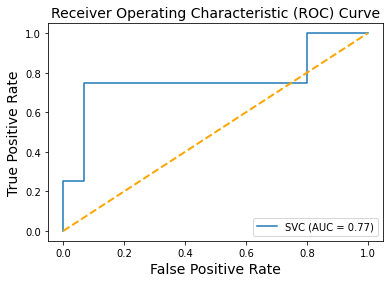

In [20]:
# plot ROC curve and calculate AUC

fig = plot_roc_curve(clf, X_test, y_test)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=14)
plt.show()

# 4. Analysis
### 4.1. Disaggregate News Used in Model Predictions

In [21]:
# get news by unit of aggregation - 5 days

# group 5 days of news together
time_unit = unit_of_aggregation
news_days = news.DATE.unique()
sub_divisions = math.ceil(len(news_days) / time_unit)

# initialize variables to save results
grouped_news = pd.DataFrame()
date_ranges = []

# cycle through each date in news period
for idx, date in enumerate(news_days):
    # non start dates of each group
    if idx % time_unit != 0:
        continue
    # special logic for last batch
    elif idx >= time_unit * (sub_divisions - 1):
        date_sub_range = pd.date_range(start=date, 
                                      end=news_days[-1])      
    else:
        date_sub_range = pd.date_range(start=date, 
                                      end=news_days[idx+time_unit-1])
    
    date_ranges.append(date_sub_range)

    # get news for time range
    time_group = len(date_ranges)
    news_text_sub = news.loc[news.DATE.isin(date_sub_range)].copy()
    news_text_sub['time_group'] = [time_group for row in range(len(news_text_sub.index))]

    grouped_news = grouped_news.append(news_text_sub)

In [22]:
# exclude last group that is lost due to shift of the target label

grouped_news = grouped_news.loc[grouped_news.time_group != 96].copy()

In [23]:
# get disaggregated news in the test dataset

test_block = grouped_news.time_group.unique()[-19:]
test_news = grouped_news.loc[grouped_news.time_group.isin(test_block)].copy()
test_news.reset_index(inplace=True,drop=True)

In [24]:
# Label the level of violence (true and predicted) for each article

true_vals = dict(zip(test_news.time_group.unique(), y_test))
pred_vals = dict(zip(test_news.time_group.unique(), y_pred))

test_ = []
pred_ = []

# get true and predicted values of violence by periods of aggregation
for group in test_news.time_group:
    test_v = true_vals[group]
    pred_v = pred_vals[group]
    test_.append(test_v)
    pred_.append(pred_v)

# save results
test_news['true_violence_lvl'] = test_
test_news['pred_violence_lvl'] = pred_

In [25]:
# get news from False Positives, False Negatives, True Positives, True Negatives

incorrect_predictions = test_news.loc[test_news.true_violence_lvl != test_news.pred_violence_lvl].copy()
fp = test_news.loc[test_news.true_violence_lvl < test_news.pred_violence_lvl].copy()
fn = test_news.loc[test_news.true_violence_lvl > test_news.pred_violence_lvl].copy()
tp = test_news.loc[(test_news.true_violence_lvl == 1) & (test_news.pred_violence_lvl == 1)].copy()
tn = test_news.loc[(test_news.true_violence_lvl == 0) & (test_news.pred_violence_lvl == 0)].copy()

In [26]:
def get_pred(true_violence, pred_violence):
    '''
    returns whether the model prediction was correctly identified as positive or negative

    Parameters:
    ———————————
    true_violence: int
        the actual level of violence
    pred_violence: int
        predicted level of violence by the model
    
    Outputs:
    ————————
    str description of performance 
    '''
    if true_violence > pred_violence:
        return 'False Negative'
    elif true_violence < pred_violence:
        return 'False Positive'
    elif (true_violence == 1) & (pred_violence == 1):
        return 'True Positive'
    elif (true_violence == 0) & (pred_violence == 0):
        return 'True Negative'

test_news['prediction_success'] = [get_pred(col1,col2) for col1, col2 in zip(test_news.true_violence_lvl, test_news.pred_violence_lvl)]

In [27]:
# get embeddings of articles only in test set

embeddings_test = []
for idx, txt in enumerate(test_news['news_text']):
    txt_embedding = embed([txt])[0]
    embeddings_test.append(txt_embedding)
    # monitor progress
    if idx % 5000 == 0:
        print(idx)

0
5000
10000
15000


In [28]:
# save embeddings 

test_news['news_embedding'] = embeddings_test

### 4.2 Visualize Embeddings

In [ ]:
# use dimensionality reduction to view news articles relations to each other

# get news
X_tsne = list(test_news.news_embedding)
# run t-SNE dimensionality reduction
X_tsne_embedded = TSNE(n_components=2, random_state=0).fit_transform(X_tsne)

In [ ]:
# save reduced dimensions

df_embeddings = pd.DataFrame(X_tsne_embedded)
df_embeddings = df_embeddings.rename(columns={0:'x',1:'y'})
df_embeddings = df_embeddings.assign(label=test_news.prediction_success.values)
df_embeddings = df_embeddings.assign(text=test_news.news_text.values)


In [ ]:
# view reduced embeddings

df_embeddings

,x,y,label,text
0,-39.850746,-69.826477,True Negative,JON ANTHONY Obama has been playing the race ca...
1,33.274860,-9.560152,True Negative,By IBRAHIM ORUKO More by this Author The race ...
2,0.650976,-13.714417,True Negative,President Uhuru Kenyatta has appealed to Kenya...
3,26.996197,-20.373787,True Negative,Three governors -- two of them newcomers and f...
4,44.193653,-14.079573,True Negative,The EACC has urged Mombasa Governor Hassan Joh...
...,...,...,...,...
17512,18.992315,-39.128757,True Negative,Kenya News: “Anybody who under estimates Raila...
17513,29.137585,-26.059834,True Negative,For the millions of you who have been feeling ...
17514,76.351242,6.958147,True Negative,By NIC CHEESEMAN More by this Author The Supre...
17515,2.920371,-19.660639,True Negative,Kenya News: President Uhuru Kenyatta will on T...


In [ ]:
# get embeddings of only incorrect predictions

fp_fn = df_embeddings.loc[(df_embeddings.label =='False Positive') | (df_embeddings.label == 'False Negative')].copy()
fp_fn

,x,y,label,text
12705,-78.383598,-12.833837,False Positive,3 A protester brandishing a machete and a knif...
12706,-41.440441,-9.545189,False Positive,You are here: Home 视频播放位置 下载安装Flash播放器 NAIROBI...
12707,-57.832691,-35.178051,False Positive,At least three people were shot dead Thursday ...
12708,-52.005238,9.943852,False Positive,"NAIROBI, Kenya – Fears of further bloodshed le..."
12709,-44.303604,-11.923236,False Positive,Related News Results of Kenya’s presidential e...
...,...,...,...,...
15973,7.065409,-37.043930,False Negative,"JERSEY CITY -- Raila Odinga, the former Prime ..."
15974,40.165321,65.381477,False Negative,Narc-Kenya leader Martha Karua was Wednesday d...
15975,25.875237,-16.955206,False Negative,CORD’s push for a referendum is facing stiff ...
15976,37.983032,24.065891,False Negative,At least two significant changes must occur fo...


In [ ]:
# visualized reduced embeddings of news

fig = px.scatter(
    df_embeddings, x='x', y='y',
    color='label', labels={'color': 'label'},
    color_discrete_sequence=px.colors.qualitative.D3, 
    title = 'Embedding Visualization')

fig.write_html("/content/test1.html")

fig.show()

In [ ]:
# visualize articles that were utilized in incorrect predictions
fig = px.scatter(
    fp_fn, x='x', y='y',
    color='label', labels={'color': 'label'},
    color_discrete_sequence=px.colors.qualitative.D3, 
    title = 'FP and FN Embedding Visualization')
fig.show()

### 4.3. Visualize news during period prior to fatal violence and during violence periods

In [ ]:
# define pre-violence and during violence time periods

pre_violence_news_groups = test_news.loc[test_news.true_violence_lvl == 1].time_group.unique()
violence_news_groups = pre_violence_news_groups+1

In [ ]:
# label pre-violence and during violence news articles

pre_violence_news = test_news.loc[test_news.time_group.isin(pre_violence_news_groups)].copy()
pre_violence_news['timing'] = 'pre-election violence'
during_violence_news = test_news.loc[test_news.time_group.isin(violence_news_groups)].copy()
during_violence_news['timing'] = 'during election violence'

pre_during_violence = pd.concat([pre_violence_news,during_violence_news])

In [ ]:
# view pre-violence news

pre_during_violence

,unique_id,DATE,NUMARTS,COUNTS,THEMES,LOCATIONS,PERSONS,ORGANIZATIONS,TONE,CAMEOEVENTIDS,SOURCES,SOURCEURLS,news_text,scraping_flag,wbm_tag,news_embedding,nelda7,nelda12,nelda14,nelda18,nelda19,nelda20,nelda28,nelda30,nelda51,nelda53,nelda57,nelda58,time_group,true_violence_lvl,pred_violence_lvl,prediction_success,timing
7948,7648219,2017-10-07,2,NaN,USPEC_POLICY1;EPU_UNCERTAINTY;LEADER;TAX_FNCAC...,"1#Germany#GM#GM#51.5#10.5#GM;4#Nakuru, Rift Va...",zacheaus okoth;joshua kutuny;musalia mudavadi;...,catholic diocese of kisumu;national assembly m...,"-1.7636684303351,3.43915343915344,5.2028218694...","695997605,695997606,695997608,695997609,695997...",standardmedia.co.ke;standardmedia.co.ke,https://www.standardmedia.co.ke/article/200125...,"| Published Sun, October 8th 2017 at 00:03, Up...",1,1,"(tf.Tensor(-0.054544218, shape=(), dtype=float...",0.185248,0.229877,0.298006,0.054702,-0.049754,0.186342,0.211811,0.268790,0.192964,0.100104,0.132517,0.179975,86,1,1,True Positive,pre-election violence
7949,6641195,2017-10-07,1,NaN,TAX_ETHNICITY;TAX_ETHNICITY_KENYAN;PROTEST;TAX...,"4#Kisumu, Nyanza, Kenya#KE#KE07#-0.10221#34.76...",ezra chiloba;uhuru kenyatta;james orengo,supreme court;kenyan supreme court,"-4.46735395189003,3.09278350515464,7.560137457...","695886853,695887405,695887409,695887411,695887620",sabc.co.za,http://www.sabc.co.za/news/a/e525328042e0bbd3b...,"Opposition, NASA supporters were back on the s...",1,1,"(tf.Tensor(-0.048936285, shape=(), dtype=float...",0.240997,0.391655,0.434928,0.057171,-0.090632,0.279259,0.303423,0.415112,0.228101,0.117971,0.197232,0.270858,86,1,1,True Positive,pre-election violence
7950,5275518,2017-10-07,3,NaN,TAX_FNCACT;TAX_FNCACT_CANDIDATE;TAX_FNCACT_RUN...,"4#Bungoma, Western, Kenya#KE#KE09#0.563504#34....",ndegwa muhoro;raila odinga;kalonzo musyoka;gay...,NaN,"-2.16606498194946,1.44404332129964,3.610108303...",NaN,standardmedia.co.ke;standardmedia.co.ke;standa...,https://www.standardmedia.co.ke/article/200125...,"| Published Sat, October 7th 2017 at 14:16, Up...",1,1,"(tf.Tensor(0.005799192, shape=(), dtype=float3...",0.226684,0.175831,0.238302,0.006229,-0.076303,0.199381,0.148572,0.259462,0.183742,0.041957,0.175428,0.180979,86,1,1,True Positive,pre-election violence
7951,1456600,2017-10-07,1,NaN,BULLYING;TAX_FNCACT;TAX_FNCACT_DIPLOMATS;WB_69...,"4#Kiharu, Central, Kenya#KE#KE01#-0.716667#37....",francis muthaura;george thuo;smith hempstone;n...,boundaries commission;head of civil service;af...,"-2.49609984399376,4.6801872074883,7.1762870514...","695999479,695999492,695999493,695999648,695999...",nation.co.ke,http://www.nation.co.ke/news/politics/-Bully--...,By OSCAR OBONYO More by this Author The visa c...,1,1,"(tf.Tensor(-0.034981277, shape=(), dtype=float...",0.137893,0.218542,0.288741,0.066967,0.041048,0.151677,0.205752,0.255421,0.215288,0.142374,0.143772,0.257636,86,1,1,True Positive,pre-election violence
7952,8317821,2017-10-07,1,NaN,GENERAL_GOVERNMENT;LEADER;TAX_FNCACT;TAX_FNCAC...,"4#Homabay, Nyanza, Kenya#KE#KE07#-0.527309#34....",millie odhiambo,kenyan parliament,"-6.71140939597315,0.671140939597315,7.38255033...",NaN,sde.co.ke,https://www.sde.co.ke/article/2001256641/notor...,Ms Millie Odhiambo Ms Millie Odhiambo is the M...,1,1,"(tf.Tensor(-0.040084288, shape=(), dtype=float...",0.100136,0.154442,0.209107,0.064738,-0.035514,0.139600,0.208676,0.176063,0.115688,0.113528,0.169801,0.149701,86,1,1,True Positive,pre-election violence
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16987,2917728,2017-11-20,1,"AFFECT#20##4#Machakos, Eastern, Kenya#KE#KE03#...",LEADER;TAX_FNCACT;TAX_FNCACT_PRESIDENT;USPEC_P...,"4#Nairobi, Nairobi Area, Kenya#KE#KE05#-1.2833...",daniel rono;raila odinga;uhuru kenyatta;winnie...,supreme court;njonjo mue international commiss...,"1.59817351598174,6.39269406392694,4.7945205479...","708431965,708431975,708431979,708431980,708431...",the-star.co.ke,https://www.the-star.co.

In [ ]:
# reduce dimensions of embeddings for pre-violence news

X_tsne = list(pre_during_violence.news_embedding)
X_tsne_embedded = TSNE(n_components=2, random_state=0).fit_transform(X_tsne)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [ ]:
# reduced embeddings dataframe

df_embeddings = pd.DataFrame(X_tsne_embedded)
df_embeddings = df_embeddings.rename(columns={0:'x',1:'y'})
df_embeddings = df_embeddings.assign(label=pre_during_violence.timing.values)
df_embeddings = df_embeddings.assign(text=pre_during_violence.news_text.values)

In [ ]:
# visualize news pre- and during-violence periods

fig = px.scatter(
    df_embeddings, x='x', y='y',
    color='label', labels={'color': 'label'},
    color_discrete_sequence=px.colors.qualitative.D3, 
    title = 'Embedding Visualization')
fig.show()

In [ ]:
# visualized average embeddings

X_tsne = X_test
X_tsne_embedded = TSNE(n_components=2, random_state=0).fit_transform(X_tsne)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [ ]:
# reduced embeddings dataframe

df_embeddings = pd.DataFrame(X_tsne_embedded)
df_embeddings = df_embeddings.rename(columns={0:'x',1:'y'})
df_embeddings = df_embeddings.assign(label=y_test)
df_embeddings = df_embeddings.assign(label2=y_pred)

In [ ]:
# view reduced embeddings and labels of violence
df_embeddings

,x,y,label,label2
0,203.083801,-20.442284,0,0
1,-96.132996,37.483326,0,0
2,-208.588409,88.246841,0,0
3,-109.608650,156.537415,0,0
4,3.952860,-126.262062,0,0
5,-90.407433,-71.413803,0,0
6,199.770584,95.815125,0,0
7,97.956985,-195.206360,0,0
8,-2.650031,92.854614,0,0
9,-3.360524,-255.063995,1,1


In [ ]:
# visualize average embeddings by true and predicted level of violence

fig = px.scatter(
    df_embeddings, x='x', y='y',
    color='label', labels={'color': 'label'}, symbol='label2',
    color_discrete_sequence=px.colors.qualitative.D3, 
    title = 'Embedding Visualization')
fig.show()

### 4.4. Visualize Embeddings pre, during, and outside of violence contexts

In [ ]:
# define pre and during violence periods

pre_violence_news_groups = test_news.loc[test_news.true_violence_lvl == 1].time_group.unique()
violence_news_groups = [87,90,94]

# label pre, during, and out-of-violence periods
pre_violence_news = test_news.loc[test_news.time_group.isin(pre_violence_news_groups)].copy()
pre_violence_news['timing'] = 'pre-election violence'
during_violence_news = test_news.loc[test_news.time_group.isin(violence_news_groups)].copy()
during_violence_news['timing'] = 'during election violence'
outside_violence_news_groups = test_news.loc[~test_news.time_group.isin(violence_news_groups) & ~test_news.time_group.isin(pre_violence_news_groups)].copy()
outside_violence_news_groups['timing'] = 'out-of-violence'

pre_during_out_violence = pd.concat([pre_violence_news,during_violence_news, outside_violence_news_groups])

In [ ]:
# reduce embeddings

X_tsne = list(pre_during_out_violence.news_embedding)
X_tsne_embedded = TSNE(n_components=2, random_state=2).fit_transform(X_tsne)

In [ ]:
# reduced embeddings dataframe

df_embeddings = pd.DataFrame(X_tsne_embedded)
df_embeddings = df_embeddings.rename(columns={0:'x',1:'y'})
df_embeddings = df_embeddings.assign(label=pre_during_out_violence.timing.values)
df_embeddings = df_embeddings.assign(text=pre_during_out_violence.news_text.values)


In [ ]:
# visualize reduced embeddings

fig = px.scatter(
    df_embeddings, x='x', y='y',
    color='label', labels={'color': 'label'},
    color_discrete_sequence=px.colors.qualitative.D3, 
    title = 'Embedding Visualization')

fig.show()

### 4.5. Topic modeling 

#### 4.5.1. Clean Text for topic modeling

In [29]:
# disaggregate the time grouping of election violence (pre, during, out-of-violence periods)

# get unique time groups
pre_violence_news_groups = test_news.loc[test_news.true_violence_lvl == 1].time_group.unique()
violence_news_groups = [87,90,94]

# label news by time groups
pre_violence_news = test_news.loc[test_news.time_group.isin(pre_violence_news_groups)].copy()
pre_violence_news.reset_index(inplace=True,drop=True)
pre_violence_news['timing'] = 'before fatal election violence'
during_violence_news = test_news.loc[test_news.time_group.isin(violence_news_groups)].copy()
during_violence_news.reset_index(inplace=True,drop=True)
during_violence_news['timing'] = 'during fatal election violence'
outside_violence_news = test_news.loc[~test_news.time_group.isin(violence_news_groups) & ~test_news.time_group.isin(pre_violence_news_groups)].copy()
outside_violence_news.reset_index(inplace=True,drop=True)
outside_violence_news['timing'] = 'no fatal election violence'

# combine dataframes of time groups
pre_during_out_violence = pd.concat([pre_violence_news,during_violence_news,outside_violence_news])


In [30]:
# Clean news text

# load spacy module
spacy_nlp = spacy.load('en_core_web_sm')

# remove urls
pre_during_out_violence['text_no_url'] = [re.sub(r'http\S+', '', row) for row in pre_during_out_violence.news_text]
pre_during_out_violence['text_no_url'] = [re.sub(r'\S+\.com', '', row) for row in pre_during_out_violence.text_no_url]
pre_during_out_violence['text_no_url'] = [re.sub(r'\S+\.COM', '', row) for row in pre_during_out_violence.text_no_url]

# custom cleaning pipeline
custom_pipeline = [hero.preprocessing.fillna, 
                   hero.preprocessing.lowercase, 
                   hero.preprocessing.remove_punctuation, 
                   hero.preprocessing.remove_diacritics,
                   hero.preprocessing.remove_stopwords,
                   hero.preprocessing.remove_html_tags, 
                   hero.preprocessing.remove_whitespace]

# apply cleaning pipeline
pre_during_out_violence['clean_text'] = hero.clean(pre_during_out_violence['text_no_url'], pipeline=custom_pipeline)

# tokenize
pre_during_out_violence['tokens'] = [word_tokenize(row) for row in pre_during_out_violence.text_no_url]
pre_during_out_violence['tokens_cleaned'] = [word_tokenize(row) for row in pre_during_out_violence.clean_text]
# remove individual undesirable words
pre_during_out_violence['tokens_cleaned'] = [[tok for tok in row if tok != 'said'] for row in pre_during_out_violence.tokens_cleaned] 
pre_during_out_violence['token_clean_sent'] = [" ".join(row) for row in pre_during_out_violence.tokens_cleaned]

#### 4.5.2. Barchart topics
- Examine Topics by time period (before, during, and outside of fatal violence periods)

In [ ]:
topic_model = BERTopic(embedding_model=model)

In [ ]:
# previolence 

docs = pre_during_out_violence.loc[pre_during_out_violence.timing == 'before fatal election violence'].token_clean_sent.astype('str')
print(len(docs))
topics, probs = topic_model.fit_transform(docs)
topic_model.reduce_topics(docs, nr_topics=20)
topic_model.visualize_barchart()

Instructions for updating:
Use tf.identity instead.


4540


In [ ]:
# during violence 
docs = pre_during_out_violence.loc[pre_during_out_violence.timing == 'during fatal election violence'].token_clean_sent.astype('str')
print(len(docs))
topics, probs = topic_model.fit_transform(docs)
topic_model.reduce_topics(docs, nr_topics=20)
topic_model.visualize_barchart()

3204


In [ ]:
# out of violence 
docs = pre_during_out_violence.loc[pre_during_out_violence.timing == 'no fatal election violence'].token_clean_sent.astype('str')
docs = docs.sample(4000, random_state=0)  # sample
print(len(docs))
topics, probs = topic_model.fit_transform(docs)
topic_model.reduce_topics(docs, nr_topics=20)
topic_model.visualize_barchart()

4000


#### 4.5.3. Topics by Class of Model Performance

In [31]:
# get categories of prediction based on model performance using sample of news

tp = pre_during_out_violence.loc[pre_during_out_violence.prediction_success == 'True Positive'].sample(1000, random_state=0)
tn = pre_during_out_violence.loc[pre_during_out_violence.prediction_success == 'True Negative'].sample(1000, random_state=0)
fp = pre_during_out_violence.loc[pre_during_out_violence.prediction_success == 'False Positive'].sample(1000, random_state=0)
fn = pre_during_out_violence.loc[pre_during_out_violence.prediction_success == 'False Negative'].sample(534, random_state=0)

# combine dataframes
sampled_pred_success = pd.concat([tp,tn,fp,fn])
sampled_pred_success.reset_index(inplace=True, drop=True)

In [32]:
# run topic modeling 

# instantiate topic model
topic_model = BERTopic()
# get news articles
docs = sampled_pred_success.token_clean_sent.astype('str')
# size of sample
print(len(docs))
# define classes - model performance
classes = sampled_pred_success.prediction_success
# fit topic model
topics, probs = topic_model.fit_transform(docs)
# extract topics per class
topics_per_class = topic_model.topics_per_class(docs, classes=classes)

3534


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [34]:
# visualize topic model results

fig = topic_model.visualize_topics_per_class(topics_per_class, width=1000, height=650, normalize_frequency=False)
fig.write_html('topics_per_class_2.html')
fig.show()

### 4.6. Model predictions over time

In [ ]:
# get model predictions by time group

plot_grouped_news = pre_during_out_violence.drop_duplicates(subset=['time_group', 'true_violence_lvl', 'pred_violence_lvl'])

# transform values for clearer visualization
plot_grouped_news.true_violence_lvl.loc[plot_grouped_news.true_violence_lvl == 0] = -0.5
plot_grouped_news.true_violence_lvl.loc[plot_grouped_news.true_violence_lvl == 1] = -3
plot_grouped_news.pred_violence_lvl.loc[plot_grouped_news.pred_violence_lvl == 0] = 0.5
plot_grouped_news.pred_violence_lvl.loc[plot_grouped_news.pred_violence_lvl == 1] = 3

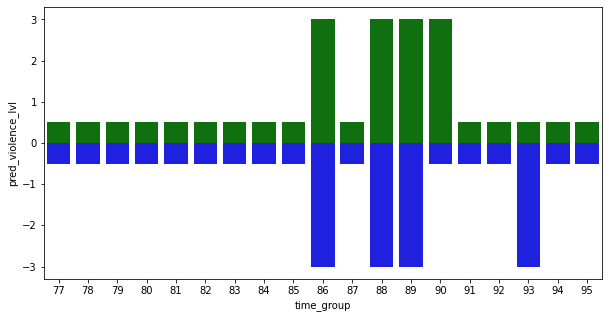

In [ ]:
# visualize model predictions

fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(10)
sns.barplot(x=plot_grouped_news.time_group, y=plot_grouped_news.true_violence_lvl, ax=ax, color='b')
sns.barplot(x=plot_grouped_news.time_group, y=plot_grouped_news.pred_violence_lvl, ax=ax, color='g')

plt.show()

In [ ]:
# get table of model predictions by time period

predictions_df = plot_grouped_news[['DATE', 'time_group', 'true_violence_lvl', 'pred_violence_lvl', 'prediction_success']].copy()
predictions_df.DATE = pd.to_datetime(predictions_df.DATE)
predictions_df = predictions_df.sort_values('DATE')
predictions_df.reset_index(inplace=True, drop=True)

In [ ]:
# view predictions and prediction success

predictions_df

# 5. Supplemental Analysis:
### 5.1. Frequency of NELDA Risk factors over time

In [ ]:
# prepare data

pre_during_out_violence.reset_index(inplace=True, drop=True)

In [ ]:
def classify_risk_factor(df):
    '''
    classifies each news article by the NELDA description it is most similar to

    Parameters:
    ———————————
    df: pandas dataframe
        news data
    Outputs:
    ————————
    max_nelda: str
      the NELDA description the news article is most similar to by cosine similarity 
    '''
    nelda_lst = dict({'nelda_7':df.nelda7, 'nelda_12':df.nelda12, 'nelda_14':df.nelda14, "nelda_18":df.nelda18,
                     'nelda_19':df.nelda19, 'nelda_20':df.nelda20, "nelda_28":df.nelda28, 'nelda_30':df.nelda30,
                     'nelda_51':df.nelda51, 'nelda_53':df.nelda53, 'nelda_57':df.nelda57, 'nelda_58':df.nelda58})
    max_nelda = max(nelda_lst, key=nelda_lst.get)
    return max_nelda

# get nelda columns list and exclude others in dataframe
nelda_cols = [re.findall(r'nelda\d+$', col) for col in pre_during_out_violence.columns]
nelda_cols = [col for col in nelda_cols if len(col)!=0]
nelda_cols = list(np.concatenate(nelda_cols).flat)

# filter dataframe by nelda columns
nelda_col_df = pre_during_out_violence[nelda_cols].copy()

# apply function to classify news by NELDA similarity
max_neldas = nelda_col_df.apply(lambda x: classify_risk_factor(x), axis=1)

In [ ]:
# save results
pre_during_out_violence['risk_factor'] = max_neldas

In [ ]:
# one-hot encode colum of most similar nelda risk factor for visualization
max_nelda_cols = pd.get_dummies(pre_during_out_violence.risk_factor)
pre_during_out_violence = pre_during_out_violence.join(max_nelda_cols)

In [ ]:
# get nelda columns only
nelda_cols = [re.findall(r'nelda_\d+$', col) for col in pre_during_out_violence.columns]
nelda_cols = [col for col in nelda_cols if len(col)!=0]
nelda_cols = list(np.concatenate(nelda_cols).flat)
nelda_cols

# group news data by date and sum the number of each NELDA risk factor
pre_during_out_violence_grouped = pre_during_out_violence.groupby('DATE').sum()[nelda_cols].reset_index()

# get the number of articles per day for normalization
num_articles = pre_during_out_violence.groupby('DATE').count()['unique_id'].values
pre_during_out_violence_grouped['num_articles'] = num_articles

# calculate a normalized value of the frequency of each NELDA per day based on differing number of articles a day
for col in nelda_cols:
    normalized_series = pre_during_out_violence_grouped[col]/pre_during_out_violence_grouped.num_articles
    pre_during_out_violence_grouped[col] = normalized_series

# visualize over test period
fig = px.line(pre_during_out_violence_grouped, x='DATE', y=nelda_cols, width=1200,
              title='News Related to Top Risk Factors of Election Violence',
             labels={'value':'Relative Article Frequency', 'DATE':'Date'})

# outline periods leading up to fatal violence and periods of fatal violence for analysis
fig.add_vrect(x0='2017-10-07', x1='2017-10-11', line_width=1.25, line_dash="dash", fillcolor="orange",opacity=0.1,)
            #  annotation_text="Before fatal election violence")
fig.add_vrect(x0='2017-10-12', x1='2017-10-16', line_width=1.25, line_dash="dash", fillcolor="red",opacity=0.1,)
            #  annotation_text="During fatal election violence")
fig.add_vrect(x0='2017-10-17', x1='2017-10-21', line_width=1.25, line_dash="dash", fillcolor="orange",opacity=0.1,)
            #  annotation_text="Before fatal election violence")
fig.add_vrect(x0='2017-10-22', x1='2017-10-31', line_width=1.25, line_dash="dash", fillcolor="red",opacity=0.1,)
            #  annotation_text="During fatal election violence")
fig.add_vrect(x0='2017-11-11', x1='2017-11-15', line_width=1.25, line_dash="dash", fillcolor="orange",opacity=0.1,)
            #  annotation_text="Before fatal election violence")
fig.add_vrect(x0='2017-11-16', x1='2017-11-20', line_width=1.25, line_dash="dash", fillcolor="red",opacity=0.1,)
            #  annotation_text="During fatal election violence")

fig.show()

### 5.2. Relation of average article Tone/Sentiment to periods of violence

In [ ]:
# extract tone values for each article
pre_during_out_violence['Avg_Tone'] = [float(row.split(',')[0]) for row in pre_during_out_violence.TONE]
pre_during_out_violence['pos_tone'] = [float(row.split(',')[1]) for row in pre_during_out_violence.TONE]
pre_during_out_violence['neg_one'] = [float(row.split(',')[2]) for row in pre_during_out_violence.TONE]

# group news data by day
pre_during_out_violence_grouped_tone = pre_during_out_violence.groupby('DATE').mean()['Avg_Tone'].reset_index()

# visualize the average tone over the test period
fig = px.line(pre_during_out_violence_grouped_tone, x='DATE', y='Avg_Tone')

# outline periods leading up to fatal violence and periods of fatal violence for analysis
fig.add_vrect(x0='2017-10-07', x1='2017-10-11', line_width=1.25, line_dash="dash", fillcolor="orange",opacity=0.1,)
            #  annotation_text="Before fatal election violence")
fig.add_vrect(x0='2017-10-12', x1='2017-10-16', line_width=1.25, line_dash="dash", fillcolor="red",opacity=0.1,)
            #  annotation_text="During fatal election violence")
fig.add_vrect(x0='2017-10-17', x1='2017-10-26', line_width=1.25, line_dash="dash", fillcolor="orange",opacity=0.1,)
            #  annotation_text="Before fatal election violence")
fig.add_vrect(x0='2017-10-27', x1='2017-10-31', line_width=1.25, line_dash="dash", fillcolor="red",opacity=0.1,)
            #  annotation_text="During fatal election violence")
fig.add_vrect(x0='2017-11-11', x1='2017-11-15', line_width=1.25, line_dash="dash", fillcolor="orange",opacity=0.1,)
            #  annotation_text="Before fatal election violence")
fig.add_vrect(x0='2017-11-16', x1='2017-11-20', line_width=1.25, line_dash="dash", fillcolor="red",opacity=0.1,)
            #  annotation_text="During fatal election violence")

fig.show()